# Bandidos multibrazo
El objetivo de este ejercicio es programar las diferentes estrategias para equilibrar exploración y explotación.

### 1. Algoritmo incremental epsilon greedy:

<img src="simple_bandit_algo.PNG">

### 2. Algoritmo no estacionario con alfa constante:

<img src="non_stationary.PNG">

### 3. Algoritmo con cota superior de confianza:

<img src="UCB.PNG">

In [1]:
from math import *

In [2]:
#%matplotlib inline
#import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
import numpy as np
#pip3 install tqdm
from tqdm import tqdm
import pdb

"""
¿Qué es esto del class? les dejo un link donde hablan de esto de manera SIMPLE :). 

https://micropyramid.com/blog/understand-self-and-__init__-method-in-python-class/
"""

class Bandit:
    # @k_arm: # de brazos
    def __init__(self, k_arm=10, true_reward=0.):
        self.k = k_arm
        self.true_reward = true_reward
    
    def reset(self):
        # recompensa real para cada acción:
        self.q_true = np.random.randn(self.k) + self.true_reward
        self.best_action = np.argmax(self.q_true)
        
    def step(self, action):
        # genera una recompensa bajo N(recompensa real, 1)
        reward = np.random.randn() + self.q_true[action]
        return reward
    
class SimpleBanditAlgo:
    # @epsilon: proabilidad de exploración para el algoritmo epsilon-greedy
    # @initial: initial estimation for each action
    def __init__(self, initial, epsilon, k_arm=10):
        self.epsilon = epsilon
        self.initial = initial
        self.k = k_arm
        self.indices = np.arange(self.k)
        self.reset()
        
    def reset(self):
        # estimación de cada acción
        self.q_estimation = np.zeros(self.k) + self.initial
        # # de veces que se eligió cada acción
        self.action_count = np.zeros(self.k)
        
    def act(self):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.indices)
        q_best = np.max(self.q_estimation)
        return np.random.choice([action for action, q in enumerate(self.q_estimation) if q == q_best])
    
    def update(self, action, reward):
        self.action_count[action] += 1
        ### COMPLETAR la próxima línea ###
        self.q_estimation[action] += (reward-self.q_estimation[action])/self.action_count[action]

    
class ConstantStepSizeAlgo:
    # @epsilon: proabilidad de exploración para el algoritmo epsilon-greedy
    # @initial: initial estimation for each action
    # @alpha: step
    def __init__(self, initial, epsilon, alpha, k_arm=10):
        self.epsilon = epsilon
        self.initial = initial
        self.alpha = alpha
        self.k = k_arm
        self.indices = np.arange(self.k)
        self.reset()
    
    def reset(self):
        # estimación de cada acción
        self.q_estimation = np.zeros(self.k) + self.initial
        # # de veces que se eligió cada acción
        self.action_count = np.zeros(self.k)
        
    def act(self):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.indices)
        q_best = np.max(self.q_estimation)
        return np.random.choice([action for action, q in enumerate(self.q_estimation) if q == q_best])
    
    def update(self, action, reward):
        self.action_count[action] += 1
        ### COMPLETAR la próxima línea ###
        self.q_estimation[action] += self.alpha * (reward - self.q_estimation[action])

class UCBAlgo:
    # @epsilon: proabilidad de exploración para el algoritmo epsilon-greedy
    # @initial: initial estimation for each action
    # @alpha: step
    def __init__(self, initial, epsilon, alpha, UCB_param, k_arm=10):
        self.epsilon = epsilon
        self.initial = initial
        self.alpha = alpha
        self.UCB_param = UCB_param
        self.k = k_arm
        self.indices = np.arange(self.k)
        self.reset()
        
    def reset(self):
        # estimación de cada acción
        self.q_estimation = np.zeros(self.k) + self.initial
        # # de veces que se eligió cada acción
        #self.action_count = np.zeros(self.k)
        self.action_count = np.ones(self.k)
        self.time = 1
    
    def act(self):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.indices)
       
        ### COMPLETAR la próxima línea ###

        UCB_estimation = [(self.q_estimation[a] + self.UCB_param*sqrt(log(self.time)/(self.action_count[a]))) for a in range(self.k)]
        
        q_best = np.max(UCB_estimation)
        return np.random.choice([action for action, q in enumerate(UCB_estimation) if q == q_best])
    
    def update(self, action, reward):
        self.time += 1
        self.action_count[action] += 1
        self.q_estimation[action] += self.alpha * (reward - self.q_estimation[action])

def simulate(runs, time, bandit, algos):
    best_action_counts = np.zeros((len(algos), runs, time))
    rewards = np.zeros((len(algos), runs, time))
    for i, algo in enumerate(algos):
        for r in tqdm(range(runs)):
            bandit.reset()
            algo.reset()
            for t in range(time):
                action = algo.act()
                reward = bandit.step(action)
                algo.update(action, reward)
                rewards[i, r, t] = reward
                if action == bandit.best_action:
                    best_action_counts[i, r, t] = 1
    best_action_counts = best_action_counts.mean(axis=1)
    rewards = rewards.mean(axis=1)
    return best_action_counts, rewards


100%|██████████| 1000/1000 [01:30<00:00, 11.01it/s]


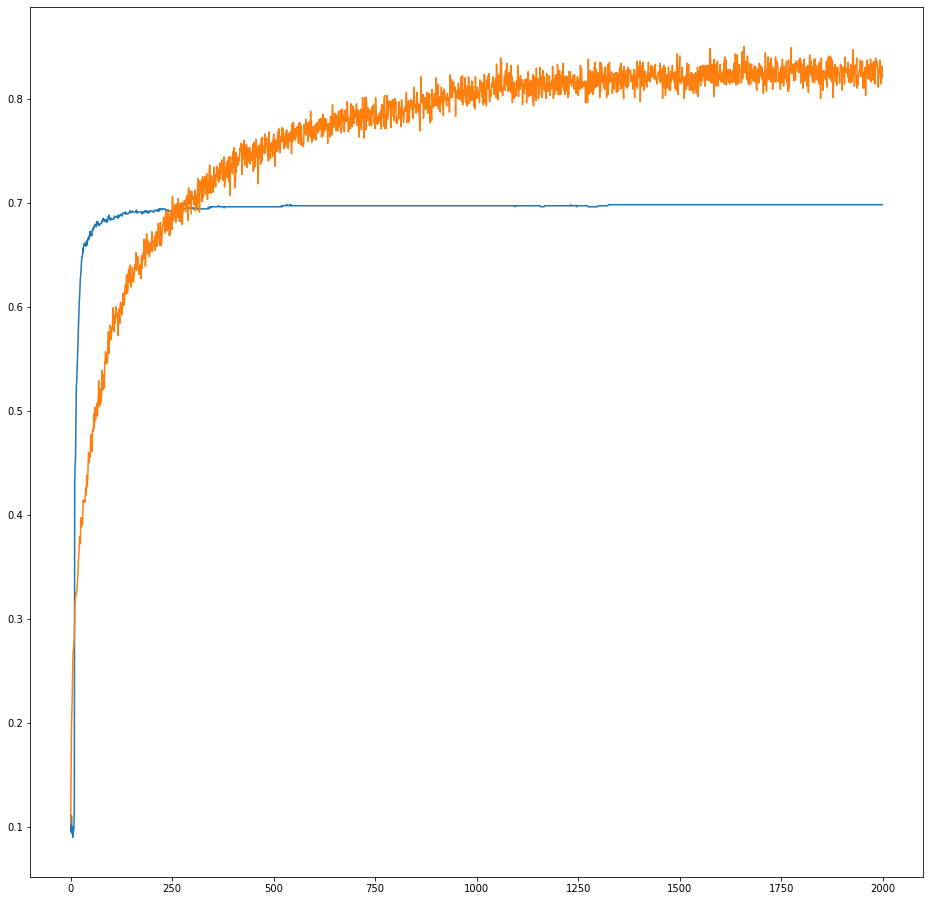

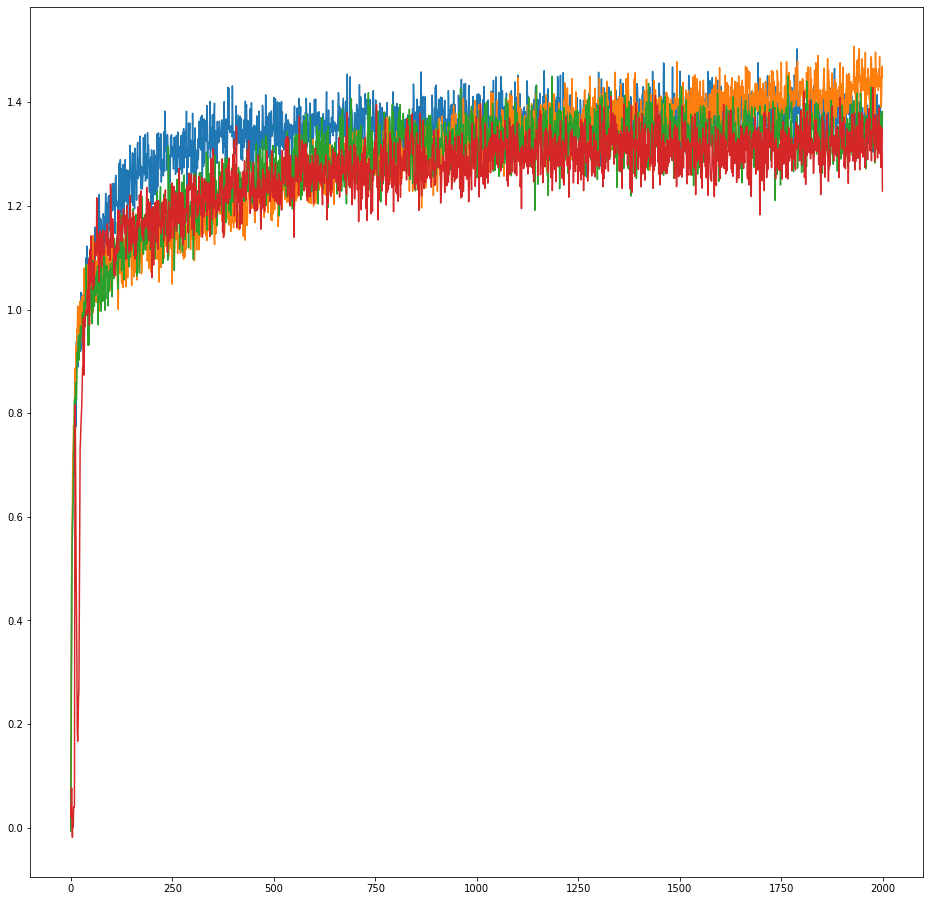

In [3]:
algos = [SimpleBanditAlgo(5, 0.0), 
         SimpleBanditAlgo(0, 0.1), 
         SimpleBanditAlgo(0, 0.01),
         ConstantStepSizeAlgo(0, 0.1, 0.1), 
         UCBAlgo(0, 0.1, 0.1, 2)]

bandit = Bandit()
best_action_counts, rewards = simulate(1000, 2000, bandit, algos)




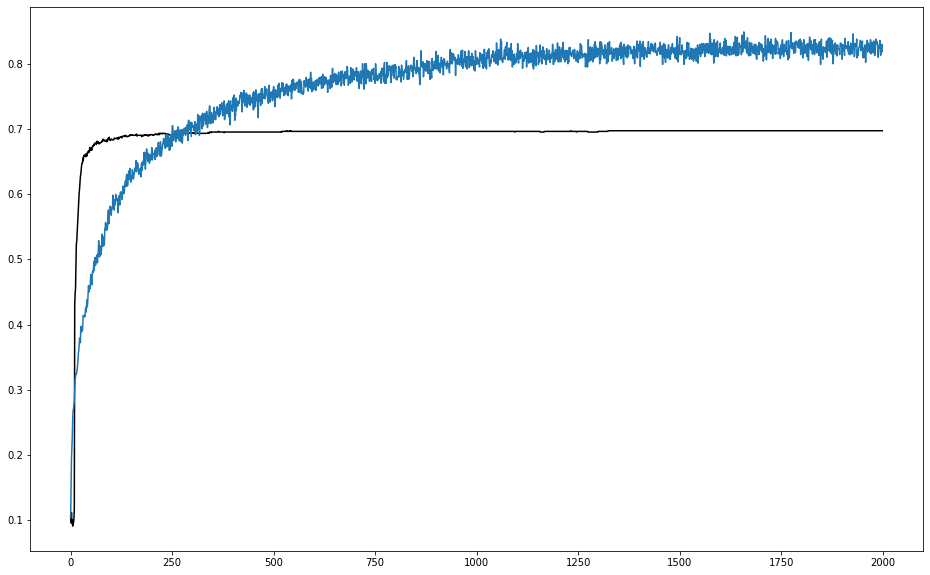

In [17]:
plt.figure(figsize=(16, 10))
plt.plot(best_action_counts[0], label='epsilon = 0, q = 5', color='black')
plt.plot(best_action_counts[1], label='epsilon = 0.1, q = 0')

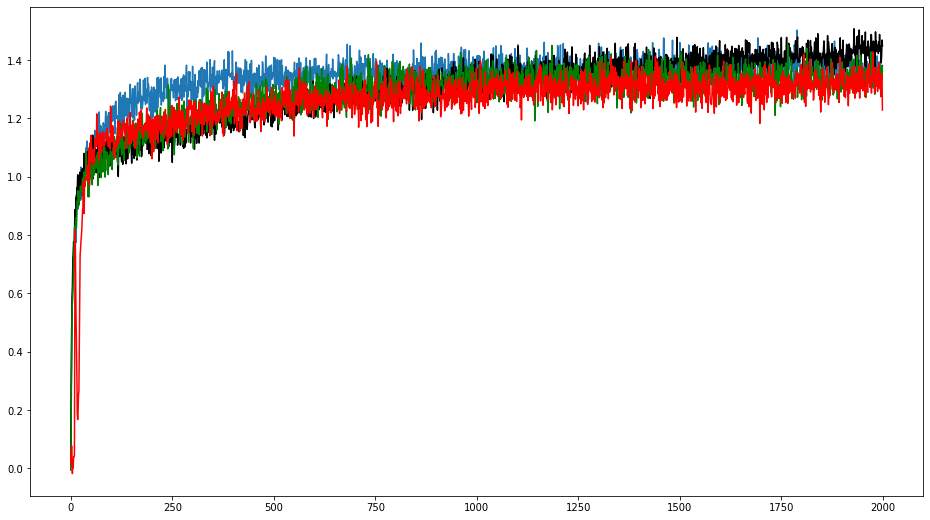

In [16]:
plt.figure(figsize=(16, 9))
plt.plot(rewards[1], label='epsilon = 0.1')
plt.plot(rewards[2], label='epsilon = 0.01', color='black')
plt.plot(rewards[3], label='alpha = 0.1, epsilon = 0.1', color='green')
plt.plot(rewards[4], label='alpha = 0.1, epsilon = 0.1, UCB param = 2', color='red')